# Exercise 9
In this exercise, you will learn about Grad-CAM, guided gradients, Grad-CAM++, and integrated gradients. You will also learn how to use these methods for trained PyTorch models.<br>
References:<br>
[Grad-Cam](https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569)<br>
[pytorch-grad-cam](https://github.com/vickyliin/gradcam_plus_plus-pytorch)<br>
[Captum](https://captum.ai/)<br>


#### Setting up deep neural network:
In this exercise, we use a pretrained deep neural network, ResNet50, which is trained for image classification. This model is trained on the ImageNet dataset and has 1000 different classes for prediction. For more information about this model, you can refer to this link:
[Resnet50](https://huggingface.co/microsoft/resnet-50)

In [1]:
%load_ext autoreload
%autoreload 2

#### Import libraries:

In [2]:
import torch
import torchvision
from torchsummary import summary
from torchvision import models, transforms
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
from skimage.io import imread
from skimage.transform import resize
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import PIL
from matplotlib import colormaps

In [3]:
model = models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V1")
model.eval();
print(summary(model, (3, 224, 224)))

# This function is defined for reconstructing the real image from a normalized image
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

# function for normalizing the image:
def preprocess_image(image_path):
    img = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor

#This function will plot the real image alongside the attribution image:
def plot(input_img, attribution):
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(attribution, cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 60.7MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Grad CAM

### What is grad-cam:


![Google Drive Image](https://drive.google.com/uc?export=view&id=1lVKRdjyjioy2TynKWbZ8LPp4-nc4o8iR)




In the Grad-CAM approach, the objective is to determine which aspects of the input image are encoded by a middle layer of a convolutional neural network (CNN), and how it represents these features for a given image. <br><br>
To achieve this, the method initially forwards the test image through the deep neural network to find the value that maximizes the output classification vector for that image, and also retrieves the values of the feature maps $(A_k)$. <br>
Next, it calculates the gradient of that score with respect to the target activation feature map $( A_k )$ and computes the mean of gradients in each channel of the feature map. These averaged gradients are denoted by $( \delta_i^c )$. Subsequently, these $( \delta_i^c )$ values serve as weights for the activation function, and a weighted sum/mean of $( A_k )$ is computed. Applying the ReLU function to the resultant image yields the Grad-CAM image.<br><br> Afterwards, the Grad-CAM image can be resized using interpolation and overlaid onto the original image for visualization.

In [4]:
# download test image:
!wget "https://wallpapercave.com/wp/7GnAy3T.jpg" -O "car1.jpg"

--2024-06-17 13:11:14--  https://wallpapercave.com/wp/7GnAy3T.jpg
Resolving wallpapercave.com (wallpapercave.com)... 104.22.52.71, 104.22.53.71, 172.67.29.26, ...
Connecting to wallpapercave.com (wallpapercave.com)|104.22.52.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282830 (276K) [image/jpeg]
Saving to: ‘car1.jpg’

car1.jpg            100%[===================>] 276.20K  --.-KB/s    in 0.03s   

2024-06-17 13:11:14 (9.17 MB/s) - ‘car1.jpg’ saved [282830/282830]



In [13]:
model.layer4[-1]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

### Implementing grad-cam from scratch:
To calculate gradients and feature maps, you can use the register_full_backward_hook and register_forward_hook functions in PyTorch:
#### register_full_backward_hook:
 This method registers a backward hook on the module, which means that the hook function will run when the backward() method is called.
The backward hook function receives as inputs the module itself, the gradients with respect to the layer’s input, and the gradients with respect to the layer’s output.

#### register_forward_hook:
This is quite similar to the previous one, except that the hook function runs in the forward pass, i.e., when the layer of interest processes its input and returns its outputs.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([1, 1000])
torch.Size([1000])
torch.return_types.max(
values=tensor(17.7225, grad_fn=<MaxBackward0>),
indices=tensor(817))
tensor(17.7225, grad_fn=<MaxBackward0>) tensor(817)
torch.Size([1, 256, 56, 56])
torch.Size([1, 256, 56, 56])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.9350e-04],
        [0.0000e+00, 5.6385e-05, 5.9211e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], grad_fn=<ReluBackward0>)


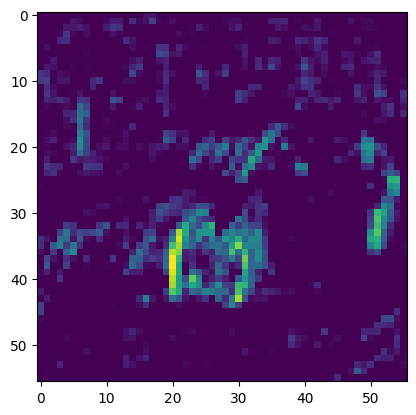

In [87]:
gradients = None
activations = None
model = models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V1")
model.eval();

def backward_hook(module, grad_input, grad_output):
  global gradients
  gradients = grad_output


def forward_hook(module, args, output):
  global activations
  activations = output


test_image = preprocess_image("car1.jpg")

#########################
# TODO bind your backward_hook and forward_hook to the last element of layer4 of your model
for_hook = model.layer1[-1].register_forward_hook(forward_hook)


back_hook = model.layer1[-1].register_backward_hook(backward_hook)
output = model(test_image)


print(output.shape)
print(output[0].shape)
print(torch.max(output[0], 0))

v, i = torch.max(output[0], 0)
print(str(v) + ' ' + str(i))

v.backward()
print(gradients[0].shape)
print(activations.shape)

gradients_mean = (torch.mean(gradients[0], dim=(0,2,3)))
wheighed_sum = 0
for i in range(len(activations[0][:])):
  activations[:,i,:,:] *= gradients_mean[i]
sumC= torch.sum(activations,dim=(0,1))
heatmap = F.relu(sumC)
print(heatmap)
########################


#########################
#TODO calculate the prediction of resnet model for test_image and find max value of score
# after that call backward() for max value
# find mean of gradient for each chanels of feature map (the gradients are in gradients)
# multiply each channel of activation to these mean values and summ all of activation maps
# feed results into relu function and save result in heatmap


# heatmap =
##########################



heatmap /= torch.max(heatmap)
plt.imshow(heatmap.detach().numpy())
for_hook.remove()
back_hook.remove()


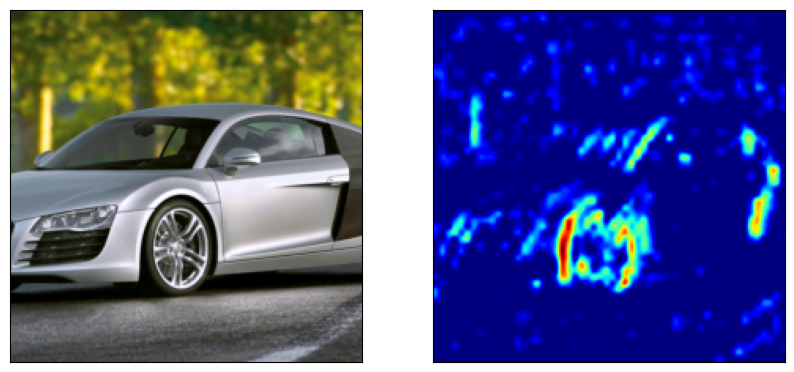

In [88]:
real_image = inv_normalize(preprocess_image("car1.jpg")[0])
overlay = to_pil_image(heatmap.detach(), mode='F').resize((224,224), resample=PIL.Image.BICUBIC)
cmap = colormaps['jet']
overlay = (255 * cmap(np.asarray(overlay))[:, :, :3]).astype(np.uint8)
plot(real_image,overlay)


### Question:
1. What is the difference between the vanilla saliency map and the Grad-CAM method?
2. Change the target CNN layer from 4 to 1 and run the code again. Explain why the gradient changes in this manner.

### Using pytorch grad-cam lib:

In [ ]:
!pip install pytorch-gradcam

In [ ]:
from gradcam import GradCAM
from gradcam.utils import visualize_cam

model = models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V1")
model.eval();

gradcam = GradCAM(model,model.layer4[-1])
torch_img = preprocess_image("car1.jpg")
real_image = inv_normalize(preprocess_image("car1.jpg")[0])

mask, _ = gradcam(torch_img)
heatmap, result = visualize_cam(mask, torch_img)
plot(real_image,np.transpose(heatmap, (1, 2, 0)))

### Guided gradients:

In [ ]:
!pip install captum

In [ ]:
from captum.attr import InputXGradient,GuidedBackprop



#TODO###############
# use captum InputXGradient and plot the input gradient with respect to indices[0]

# attribution =
####################


#TODO###############
# use captum GuidedBackprop and plot the guided gradients with respect to indices[0]
# attribution_guided =
####################


plot(real_image,np.transpose(attribution[0].detach().numpy()*10, (1,2,0)))
plot(real_image,np.transpose(attribution_guided[0].detach().numpy()*10, (1,2,0)))


### Question:
1. Explain the difference between input gradients and guided gradients?
look at this [Link](https://medium.com/@chinesh4/generalized-way-of-interpreting-cnns-a7d1b0178709)
2. How does guided gradient help to provide better attribution?

## Grad-Cam ++

In [ ]:
from captum.attr import GuidedGradCam

guided_gc = GuidedGradCam(model, model.layer4[-1])
attribution_gradcam_guided = guided_gc.attribute(torch_img, indices[0])

plot(real_image,np.transpose(attribution_gradcam_guided[0].detach().numpy()*5, (1,2,0)))

## Question:
1. Can you explain the difference between GradCAM and GradCAM++?
2. How does GradCAM++ help to provide better attribution?

## Integrated Gradients

### Question:
please read this [Link](https://arxiv.org/abs/1703.01365) and answer the following questions:
1. What is Sensivity and Implementation Invariance in atributions methods?<br>
2. Explain how IG method work?


In [ ]:
!pip install captum

In [ ]:
from captum.attr import IntegratedGradients
model = models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V1")

torch_img = preprocess_image("car1.jpg")
real_image = inv_normalize(preprocess_image("car1.jpg")[0])


model.eval();
preds = model(test_image)
score, indices = torch.max(preds, 1)
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(torch_img, target=indices[0], n_steps=200)

In [ ]:
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(torch_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:
from captum.attr import NoiseTunnel

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(torch_img, nt_samples=10, nt_type='smoothgrad_sq', target=indices[0])


In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(torch_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)